In [1]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, Flatten, Lambda, Reshape, BatchNormalization, concatenate, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import random
import cv2
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError, Mean, binary_crossentropy, binary_accuracy
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
try:
    import google.colab
    in_colab = True
except ImportError:
    in_colab = False

if in_colab:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        tpu_strategy = tf.distribute.TPUStrategy(tpu)
    except ValueError:
        if 'GPU' in [gpu[-1] for gpu in tf.config.list_physical_devices('GPU')]:
            print('Running on Google Colab GPU')
        else:
            print('Not connected to a TPU or GPU runtime')

else:
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    try:
        if len(physical_devices):
            for gpu in physical_devices:
                tf.config.experimental.set_memory_growth(gpu, enable = True)
                print(f"Using local GPU: {gpu}")
            sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(log_device_placement = True))
        else:
            print("No local GPU found")
    except:
        print("Error Mounting a GPU")

Not connected to a TPU or GPU runtime


In [4]:
def filter_df(df, viable_nums=["2", "4", "6"]):
    condition = df['low_res'].str.endswith(tuple(num + ".jpg" for num in viable_nums))
    filtered_df = df[condition]
    return filtered_df

In [5]:
def read_images(df):
    new_df = pd.DataFrame(columns=["low_res", "high_res"])

    for index, row in df.iterrows():
            low_res_path = row["low_res"]
            low_res_img = Image.open(low_res_path)
            low_res_array = np.array(low_res_img)

            high_res_path = row["high_res"]
            high_res_img = Image.open(high_res_path)
            high_res_array = np.array(high_res_img)
            new_row = {
                "low_res" : low_res_array,
                "high_res" : high_res_array,
            }
            new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)

    return new_df

In [6]:
EPOCHS = 100
seed = 42
LAMBDA = 100
NUM_STEPS = 40000

INPUT_SHAPE = (400, 600, 3)
IMAGE_SHAPE = (400, 600)
BATCH_SIZE = 32

## Data

In [7]:
def load_and_preprocess_image(low_res_path, high_res_path):
    low_res_image = tf.io.read_file(low_res_path)
    low_res_image = tf.image.decode_jpeg(low_res_image, channels=3)
    low_res_image = tf.image.resize(low_res_image, IMAGE_SHAPE)
    low_res_image = low_res_image / 255.0

    high_res_image = tf.io.read_file(high_res_path)
    high_res_image = tf.image.decode_jpeg(high_res_image, channels=3)
    high_res_image = tf.image.resize(high_res_image, IMAGE_SHAPE)
    high_res_image = high_res_image / 255.0

    return low_res_image, high_res_image

def create_dataset(data, data_dir, batch_size):
    low_res_paths = data['low_res'].apply(lambda x: os.path.join(data_dir, 'low res', x)).values
    high_res_paths = data['high_res'].apply(lambda x: os.path.join(data_dir, 'high res', x)).values

    dataset = tf.data.Dataset.from_tensor_slices((low_res_paths, high_res_paths))
    dataset = dataset.map(load_and_preprocess_image)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Define constants
BATCH_SIZE = 16
DATA_DIR = '/content/drive/MyDrive/Image Super Resolution - Unsplash'

# Load CSV file
csv_path = os.path.join(DATA_DIR, 'image_data.csv')
df = pd.read_csv(csv_path)

# Split data into train, validation, and test sets
train_data, val_test_data = train_test_split(df, test_size=0.2, random_state=seed)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=seed)

# Create datasets
train_dataset = create_dataset(train_data, DATA_DIR, BATCH_SIZE)
val_dataset = create_dataset(val_data, DATA_DIR, BATCH_SIZE)
test_dataset = create_dataset(test_data, DATA_DIR, BATCH_SIZE)

# Print dataset information
print("Train dataset:", train_dataset)
print("Validation dataset:", val_dataset)
print("Test dataset:", test_dataset)

Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 600, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 600, 3), dtype=tf.float32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 600, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 600, 3), dtype=tf.float32, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 600, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 600, 3), dtype=tf.float32, name=None))>


In [8]:
len(train_dataset) * BATCH_SIZE

3024

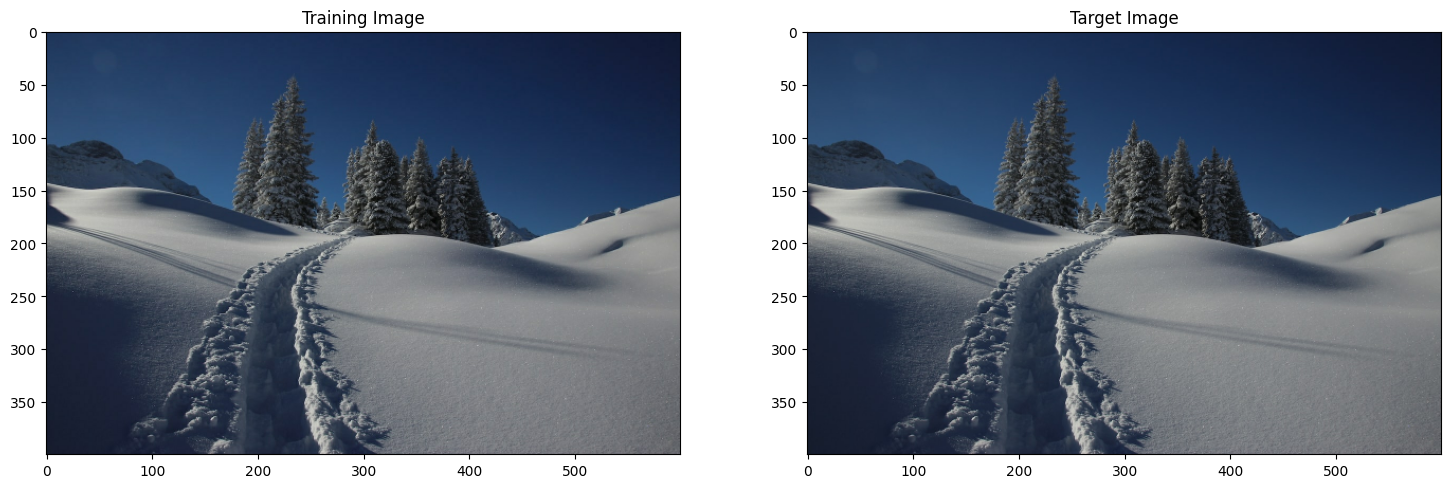

In [9]:
# Create an iterator for the train_dataset
train_iterator = iter(train_dataset)

# Get a batch of training examples
batch_of_images, batch_of_targets = next(train_iterator)

# Visualize the first training example and its target
sample_training_image = batch_of_images[0].numpy()
sample_target_image = batch_of_targets[0].numpy()

# Display the images
plt.figure(figsize=(18, 14))
plt.subplot(1, 2, 1)
plt.imshow(sample_training_image)
plt.title("Training Image")

plt.subplot(1, 2, 2)
plt.imshow(sample_target_image)
plt.title("Target Image")

plt.show()

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
tensorboard = TensorBoard(log_dir='logs')

In [11]:
def downsample(filters, kernel_size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, kernel_size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [12]:
def make_generator_model(input_shape=INPUT_SHAPE):
    # Input layer
    input_img = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(8, (3, 3), padding='same', activation='elu')(input_img)
    conv2 = Conv2D(16, (3, 3), padding='same', activation='elu')(conv1)
    conv3 = Conv2D(32, (3, 3), padding='same', activation='elu')(conv2)
    conv4 = Conv2D(64, (3, 3), padding='same', activation='elu')(conv3)
    concat1 = concatenate([conv2, conv4], axis=-1)
    conv5 = Conv2D(64, (3, 3), padding='same', activation='elu')(concat1)
    output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv5)

    # Create the model
    generator_model = Model(inputs=input_img, outputs=output_img)
    return generator_model

In [13]:
def make_discriminator_model(input_shape=INPUT_SHAPE):
  initializer = tf.random_normal_initializer(0., 0.02)
  input_image = tf.keras.layers.Input(shape=INPUT_SHAPE, name='input_image')
  target_image = tf.keras.layers.Input(shape=INPUT_SHAPE, name='target_image')
  concatenated_images = tf.keras.layers.concatenate([input_image, target_image])
  downsample1 = downsample(32, 3, False)(concatenated_images)
  downsample2 = downsample(128, 3)(downsample1)
  downsample3 = downsample(256, 3)(downsample2)
  zero_padding1 = tf.keras.layers.ZeroPadding2D()(downsample3)
  conv1 = tf.keras.layers.Conv2D(512, 3, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_padding1)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv1)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  zero_padding2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
  discriminator_output = tf.keras.layers.Conv2D(1, 3, strides=1,
                                kernel_initializer=initializer)(zero_padding2)
  return tf.keras.Model(inputs=[input_image, target_image], outputs=discriminator_output)

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['LR Image', 'HR Image', 'GAN Output']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [16]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  return total_gen_loss, gan_loss, l1_loss

In [17]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [18]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 600, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 400, 600, 8)          224       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 400, 600, 16)         1168      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 400, 600, 32)         4640      ['conv2d_1[0][0]']            
                                                                                              

In [19]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 400, 600, 3)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 400, 600, 3)]        0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 400, 600, 6)          0         ['input_image[0][0]',         
 )                                                                   'target_image[0][0]']        
                                                                                                  
 sequential (Sequential)     (None, 200, 300, 32)         1728      ['concatenate_1[0][0]'] 

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
tf.config.run_functions_eagerly(True)

In [22]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)

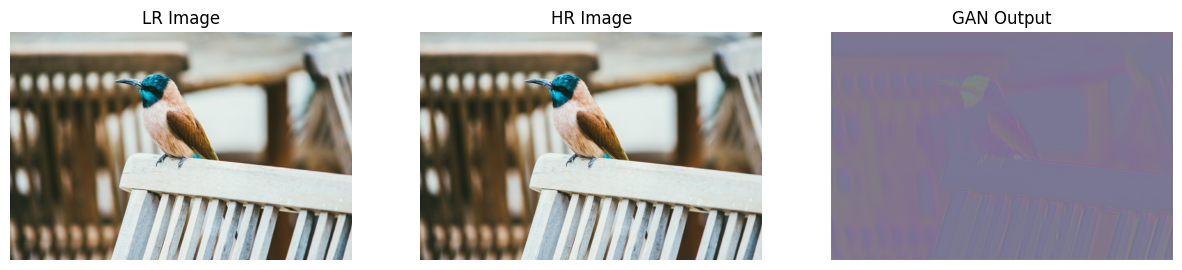

Step: 0k


In [ ]:
best_val_loss = float('inf')
early_stopping_patience = 10
early_stopping_counter = 0

train_gen_losses = []
train_disc_losses = []
avr_train_gen_losses = []
avr_train_disc_losses = []
val_gen_losses = []
val_disc_losses = []

mae_list = []
mse_list = []
accuracy_list = []

@tf.function
def train_step(input_image, target, step_counter):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_output = generator(input_image, training=True)

    real_output_disc = discriminator([input_image, target], training=True)
    generated_output_disc = discriminator([input_image, generated_output], training=True)

    total_gen_loss, gan_gen_loss, l1_gen_loss = generator_loss(generated_output_disc, generated_output, target)
    disc_loss = discriminator_loss(real_output_disc, generated_output_disc)

  gen_gradients = gen_tape.gradient(total_gen_loss, generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))


start_time = time.time()

def train(training_dataset, testing_dataset, total_steps):
  example_input, example_target = next(iter(testing_dataset.take(1)))
  start = time.time()

  for step, (input_image, target) in training_dataset.repeat().take(total_steps).enumerate():
    if (step) % 1000 == 0:

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time() - start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('-', end='', flush=True)

train(train_dataset, test_dataset, total_steps=NUM_STEPS)
end_time = time.time()
training_time = end_time - start_time
model_name = "GANs"
time_dict = {model_name: training_time}

print("Finished!")

In [ ]:
train_iterator = iter(train_dataset)

# Get a batch of training examples
batch_of_images, batch_of_targets = next(train_iterator)

# Visualize the first training example and its target
sample_training_image = batch_of_images[0].numpy()
sample_target_image = batch_of_targets[0].numpy()
sample_target_image = generator(sample_target_image[np.newaxis,:])
sample_target_image = np.reshape(sample_target_image, (400,600,3))
# Display the images
plt.figure(figsize=(18, 14))
plt.subplot(1, 2, 1)
plt.imshow(sample_training_image)
plt.title("Training Image")

plt.subplot(1, 2, 2)
plt.imshow(sample_target_image)
plt.title("Super-resolution Image")

plt.show()